# Problem Definition

*The problem* with Amazon’s Reviews is that it misses the context. Say for Example,
1. It doesn’t say whether the **battery life is good or bad**.
2. Memory card is **good/bad, available/not available**.
3. Camera Quality is **good or bad**.

To that end I formulate the problem as following:

**Problem Statement**  
The goal is to identify the *polarity / opinion* of the most prevalent *characteristics / aspects* of a product that have been reviewed. For this purpose the designed method extracts adjective-noun pairs from the review text in the dataset to determine which elements to evaluate. The adjectives in these pairs are used to determine *polarity*, whereas the nouns in these pairs are used to choose *aspects*.

# Proposed Method

The intiution behind this method relies on the connection from modifiers to nouns, pronouns, and verbs. Nouns and verbs make straightforward statements about what things are and what they do. However, the world is not black and white – there are infinite details that need to be expressed. Modifiers give additional information about nouns, pronouns, verbs, and themselves to make those things more definite. There are two types of *modifiers*: **adjectives** and **adverbs**.

*Adjectives*
1. Adjectives are words that modify nouns and pronouns. Adjectives answer the questions: What kind? Which one? And how many?
        a. What kind? Yellow balls, endangered species, gigantic tower
        b. Which one? His girlfriend, that sofa, whose music
        c. How many/much? Both books, several hours, more time
2. Adjectives may come before or after a noun. They may also come at the end of a sentence with a “to be” verb
        a. Blue dolphins play in the Pacific.
        b. The portrait, priceless to collectors, was stolen out of the museum last night.
        c. Lipstick is expensive.

As an example, a word with $nsubj$ dependency relationship with a verb token would be the $noun$ of the phrase, and a word with $acomp$ dependency relationship would be the $adjective$ of this $noun$. Thus, we would extract this pair as a relevat aspect-modifier pair.

#### Rules for dependency parse

$M$ - Sentiment modifier | $A$ - Aspect  
1. $M$ is child of A with a relationship of $\verb |amod|$.
2. Adjectival Complement - $A$ is a child of something with relationship of $\verb |nsubj|$, while $M$ is a child of the same something with relationship of $\verb|acomp|$.
    (Assumption - A verb will have only one $\verb |nsubj|$ and $\verb |dobj|$)
3. Adverbial modifier to a passive verb - $A$ is a child of something with relationship of $\verb |nsubjpass|$, while $M$ is a child of the same something with relationship of $\verb |advmod|$.  
    (Assumption - A verb will have only one $\verb |nsubj|$ and $\verb |dobj|$)
4. Complement of a copular verb - $A$ is a child of $M$ with relationship of $\verb |nsubj|$, while $M$ has a child with relationship of $\verb |cop|$.  
    (Assumption - A verb will have only one $\verb |nsubj|$ and $\verb |dobj|$)

# Implementation
*For the implemetation of above rules I used Spacy for linguistic processing, pandas to read and manage data*.

### Import required libraries

In [1]:
import spacy
import pandas as pd
from spacy import displacy
import warnings
from IPython.display import Image
warnings.filterwarnings('ignore')

%pprint

Pretty printing has been turned OFF


### Read the data

In [2]:
raw_data = pd.read_csv('data/raw/Womens_Clothing_E-Commerce_Reviews.csv')
raw_data.drop('Unnamed: 0', axis=1, inplace=True)
df = pd.DataFrame(raw_data[['Clothing ID','Title', 'Review Text']])
df.dropna(inplace=True)
df = df[df['Clothing ID'] == 1078]
len(df) # 871
nlp=spacy.load("en_core_web_lg")

### Aspect - Modifier extraction

The objective of this step is to extract instances of product aspects and modifiers that express the opinion about a particular aspect. The dependency parser tree in Python's $\verb |spaCy|$ package is utilized to extract pairs of words based on specific syntactic dependency paths. The output of this step is a dictionary of such noun-adjective which serve as the input to the next step of grouping aspects.

Since the dependency grammar assumes a very intricate logic behind any language.

Look at the sentence below -

    The delivery was very late!  

In layman's term, we want the model to extract $\verb |(delivery,late)|$ as the aspect-modifier pair. Looking at it closely, these words are basically noun & adjective pairs. And hence, there exists an underlying relationship and meaning behind these words that we can exploit using the dependency parsing tree by curating custom rules.

### Dependency parsing example

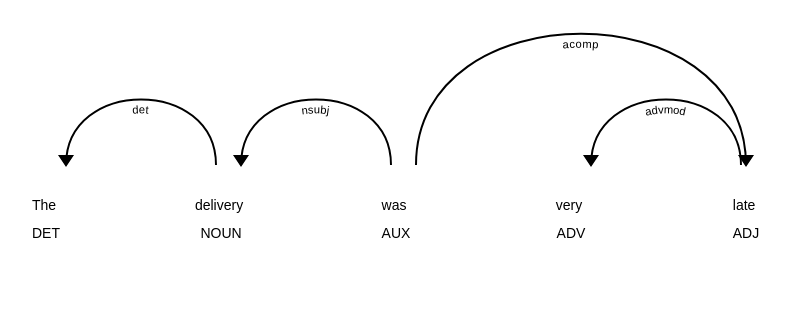

In [3]:
doc = nlp("The delivery was very late")
# displacy.serve(doc, style="dep")
Image(filename='dep_ex.png')

### Rules for aspect extraction

In [4]:
def apply_extraction(row,nlp):
    review_body = row['Review Text']
    Title = row['Title']

    doc=nlp(review_body)

    '''
    FIRST RULE OF DEPENDANCY PARSE -
    M - Sentiment modifier || A - Aspect
    RULE = M is child of A with a relationship of amod
    '''
    rule1_pairs = []
    for token in doc:
        if token.dep_ == "amod":
            rule1_pairs.append((token.head.lemma_, token.text))

    '''
    SECOND RULE OF DEPENDANCY PARSE -
    M - Sentiment modifier || A - Aspect
    Adjectival Complement - A is a child of something with relationship ofnsubj,
    while M is a child of the same something with relationship of acomp
    Assumption - A verb will have only one NSUBJ and DOBJ
    '''
    rule2_pairs = []
    for token in doc:

        children = token.children
        A = "999999"
        M = "999999"
        for child in children :
            if(child.dep_ == "nsubj"):
                A = child.lemma_

            if(child.dep_ == "acomp"):
                M = child.text

        if(A != "999999" and M != "999999"):
            rule2_pairs.append((A, M))
    
    '''
    THIRD RULE OF DEPENDANCY PARSE -
    M - Sentiment modifier || A - Aspect
    Adverbial modifier to a passive verb - A is a child of something with
    relationship of nsubjpass, while M is a child of the same something with
    relationship of advmod.
    Assumption - A verb will have only one NSUBJ and DOBJ
    '''
    rule3_pairs = []
    for token in doc:


        children = token.children
        A = "999999"
        M = "999999"
        for child in children :
            if(child.dep_ == "nsubjpass"):
                A = child.lemma_

            if(child.dep_ == "advmod"):
                M = child.text

        if(A != "999999" and M != "999999"):
            rule3_pairs.append((A, M))

    '''
    FOURTH RULE OF DEPENDANCY PARSE -
    M - Sentiment modifier || A - Aspect
    Complement of a copular verb - A is a child of M with relationship of nsubj,
    while M has a child with relationship of cop.
    Assumption - A verb will have only one NSUBJ and DOBJ
    '''
    rule4_pairs = []
    for token in doc:
        children = token.children
        A = "999999"
        buf_var = "999999"
        for child in children :
            if(child.dep_ == "nsubj"):
                A = child.lemma_

            if(child.dep_ == "cop"):
                buf_var = child.text

        if(A != "999999" and buf_var != "999999"):
            rule4_pairs.append((A, token.text))

    aspects = []
    aspects = rule1_pairs + rule2_pairs + rule3_pairs +rule4_pairs
    dikt = {}
    for tupl in aspects:
        if tupl[0] in dikt.keys():
            dikt[tupl[0]].append(tupl[1])
        else:
            dikt[tupl[0]] = [tupl[1]]
    return dikt

### Applied to all the reviews with $Clothing ID$ 1087

In [5]:
df['Review Aspects'] = df.apply(lambda row: apply_extraction(row, nlp), axis=1)    

### Modified dataframe schema

In [6]:
df.head()

,Clothing ID,Title,Review Text,Review Aspects
69,1078,Great summer fabric!,"I really wanted this to work. alas, it had a s...","{'fit': ['strange', 'weird'], 'fabric': ['beau..."
90,1078,Sweet flattering dress,"I love cute summer dresses and this one, espec...","{'dress': ['cute', 'perfect'], 'foot': ['curvy..."
467,1078,Great sweater dress!,"Nice fit and flare style, not clingy at all. i...","{'style': ['Nice', 'fit', 'clingy'], 'large': ..."
470,1078,"Cute, but cheap",When i first opened this dress and tried it on...,"{'weight': ['recent'], 'ironing': ['good'], 'i..."
474,1078,Super cute and flattering too,I love this sweater dress and get compliments ...,"{'review': ['other'], 'pattern': ['fun'], 'mat..."


### Example results from the method

In [7]:
print('Title: ', df.loc[69]['Title'])
print('Review Text: ', df.loc[69]['Review Text'])
print('Review Aspect: ', df.loc[69]['Review Aspects'])
print('\n')
print('Title: ', df.loc[90]['Title'])
print('Review Text: ', df.loc[90]['Review Text'])
print('Review Aspect: ', df.loc[90]['Review Aspects'])
print('\n')
print('Title: ', df.loc[470]['Title'])
print('Review Text: ', df.loc[470]['Review Text'])
print('Review Aspect: ', df.loc[470]['Review Aspects'])
print('\n')
print('Title: ', df.loc[474]['Title'])
print('Review Text: ', df.loc[474]['Review Text'])
print('Review Aspect: ', df.loc[474]['Review Aspects'])

Title:  Great summer fabric!
Review Text:  I really wanted this to work. alas, it had a strange fit for me. the straps would not stay up, and it had a weird fit under the breast. it worked standing up, but the minute i sat down it fell off my shoulders. the fabric was beautiful! and i loved that it had pockets.
Review Aspect:  {'fit': ['strange', 'weird'], 'fabric': ['beautiful']}


Title:  Sweet flattering dress
Review Text:  I love cute summer dresses and this one, especially because it is made out of linen, is unique. it is very well-made with a design that is quite flattering. i am 5 foot 6 and a little curvy with a 38 c bust and i got a size 10. it fits well although it is difficult to zip up because the material has no give. the perfect dress to wear to italy or france! now i just have to book my tickets!
Review Aspect:  {'dress': ['cute', 'perfect'], 'foot': ['curvy'], 'it': ['made', 'difficult', 'especially'], 'that': ['flattering']}


Title:  Cute, but cheap
Review Text:  When

The output dataframe has one additional column for the predictions. It is a dictionary where the keys of the dictionary are the characterstics / aspects of the product and the values of the dictionary is a list containing opinions about the characterstics / aspects.

**<p style="text-align: center;"> $\verb |{aspects : [opinion_1, opinion_2 . . . ]}|$ </p>**

For example consider:

    Title:  Great summer fabric!  
    
    Review Text:  I really wanted this to work. alas, it had a strange fit for me. the straps would not stayup, and it had a weird fit under the breast. it worked standing up, but the minute i sat down it fell off my shoulders. the fabric was beautiful! and i loved that it had pockets.  
    
    Review Aspect:  {'fit': ['strange', 'weird'], 'fabric': ['beautiful']}  
      
The tags can be interpreted as:  

    strange fit, weied fit, beautiful fabric